In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are dls.show_batch(max_n=6)available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## SPLITTING THE DATA

In [2]:
import zipfile

with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    


In [3]:
train = "/kaggle/working/train"
test = "/kaggle/working/test"
transducer = "/kaggle/working/transducer"

In [4]:
import os
import shutil
import random

def organize_train_folder(train_folder):
    cat_folder = os.path.join(train_folder, 'cat')
    dog_folder = os.path.join(train_folder, 'dog')

    if not os.path.exists(cat_folder):
        os.makedirs(cat_folder)
    if not os.path.exists(dog_folder):
        os.makedirs(dog_folder)

    for filename in os.listdir(train_folder):
        file_path = os.path.join(train_folder, filename)
        if os.path.isfile(file_path):
            if filename.startswith('cat'):
                shutil.move(file_path, os.path.join(cat_folder, filename))
            elif filename.startswith('dog'):
                shutil.move(file_path, os.path.join(dog_folder, filename))


def count_pictures(folder):
    dog_count = 0
    cat_count = 0
    for subfolder in ['dog', 'cat']:
        path = os.path.join(folder, subfolder)
        for filename in os.listdir(path):
            if filename.startswith('dog'):
                dog_count += 1
            elif filename.startswith('cat'):
                cat_count += 1
    return dog_count, cat_count

def create_folder_with_subfolders(source_folder, target_folder, percentage=0.30):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
        os.makedirs(os.path.join(target_folder, 'dog'))
        os.makedirs(os.path.join(target_folder, 'cat'))

    dogs = [f for f in os.listdir(os.path.join(source_folder, 'dog'))]
    cats = [f for f in os.listdir(os.path.join(source_folder, 'cat'))]

    num_dogs_to_select = int(len(dogs) * percentage)
    num_cats_to_select = int(len(cats) * percentage)

    selected_dogs = random.sample(dogs, num_dogs_to_select)
    selected_cats = random.sample(cats, num_cats_to_select)

    for filename in selected_dogs:
        shutil.move(os.path.join(source_folder, 'dog', filename), os.path.join(target_folder, 'dog', filename))

    for filename in selected_cats:
        shutil.move(os.path.join(source_folder, 'cat', filename), os.path.join(target_folder, 'cat', filename))

# Assuming your train folder is already populated with cat and dog images
train = "/kaggle/working/train"

# Organize train folder
organize_train_folder(train)

# Create transducer and test folders
create_folder_with_subfolders(train, 'transducer')
create_folder_with_subfolders(train, 'test', 0.2)

# Count pictures in train, test, and transducer folders
train_dog_count, train_cat_count = count_pictures(train)
test_dog_count, test_cat_count = count_pictures('test')
transducer_dog_count, transducer_cat_count = count_pictures('transducer')

print(f"Train - Dogs: {train_dog_count}, Cats: {train_cat_count}")
print(f"Test - Dogs: {test_dog_count}, Cats: {test_cat_count}")
print(f"Transducer - Dogs: {transducer_dog_count}, Cats: {transducer_cat_count}")


Train - Dogs: 7000, Cats: 7000
Test - Dogs: 1750, Cats: 1750
Transducer - Dogs: 3750, Cats: 3750


## TRAINING THE RESNET MODEL

In [5]:
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
image_path = "/kaggle/working/train"

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(200, method='squish')]
).dataloaders(image_path, bs=32)


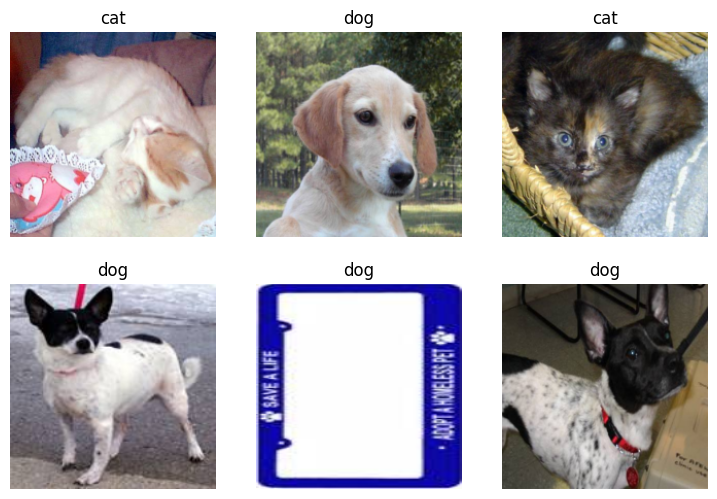

In [8]:
dls.show_batch(max_n=6)

In [9]:


learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 267MB/s]


## TRANSDUCER DATAFRAME

In [10]:
transducer_df = pd.DataFrame([], columns=['RNOutput', 'TrueLabel']) 

In [11]:

from fastai.vision.core import load_image

transducer_folder = Path('/kaggle/working/transducer')

# List all images in the test folder
transducer_images = os.listdir(transducer_folder)

In [12]:
from fastai.vision.core import load_image
import pandas as pd
import os
from pathlib import Path

transducer_folder = Path('/kaggle/working/transducer')

# Initialize DataFrame
transducer_df = pd.DataFrame(columns=['Predicted', 'Actual'])

# Function to process each image
def process_image(image_path, label):
    img_fastai = load_image(image_path)
    pred_class, pred_idx, outputs = learn.predict(img_fastai)
    return {'Predicted': pred_class, 'Actual': label}

# Iterate over each subfolder ('cat' and 'dog') and process images
results = []
for label in ['cat', 'dog']:
    subfolder_path = transducer_folder / label
    if subfolder_path.exists() and subfolder_path.is_dir():
        for image_file in subfolder_path.iterdir():
            if image_file.is_file():
                result = process_image(image_file, label)
                results.append(result)

                
                
transducer_df = pd.DataFrame(results)

In [13]:
transducer_df.head()

Predicted Actual
0       cat    cat
1       cat    cat
2       cat    cat
3       cat    cat
4       cat    cat

## EXPORTS

In [14]:
transducer_df.to_csv('transducer_dataframe.csv', index=False)

In [15]:
learn.export('resnet18.pkl')

In [16]:
import zipfile
import os

def zip_folder(folder_path, output_file):
    with zipfile.ZipFile(output_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Create a proper path relative to the folder being zipped
                file_path = os.path.join(root, file)
                file_path_in_zip = os.path.relpath(file_path, os.path.dirname(folder_path))
                # Add file to the zip file
                zipf.write(file_path, file_path_in_zip)

# Path to your test folder
test_folder = "/kaggle/working/test"

# Path where you want to save the zip file
zip_file_path = "/kaggle/working/test.zip"

# Zip the test folder
zip_folder(test_folder, zip_file_path)

print(f"Folder '{test_folder}' has been zipped to '{zip_file_path}'")


Folder '/kaggle/working/test' has been zipped to '/kaggle/working/test.zip'
